# Create a New Bathymetry for GoMSS

In [1]:
%matplotlib inline

# import modules
import sys
import os
import xarray as xr
import pandas as pd
import numpy as np
import netCDF4 as nc
import time
import mpl_toolkits.basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from matplotlib import path
from cmocean import cm

modpath = os.path.abspath(os.path.join('/home/chrenkl/Projects/MDT_tilt/Python'))
if modpath not in sys.path:
    sys.path.append(modpath)

import nemo_tools as nt
from create_bathymetry import read_etopo,            \
                              read_gebco,            \
                              read_insitu,           \
                              read_webtide,          \
                              etopo2nemo,            \
                              gebco2nemo,            \
                              optimal_interpolation, \
                              oi_gaspari_cohn,       \
                              land_sea_mask,         \
                              minimum_depth,         \
                              remove_closed_seas

In [2]:
# project directory
projdir = '/home/chrenkl/Projects/nemo_bathymetry'

# NEMO configuration
conf = 'GoMSS'

# WebTide data set
wtset = 'nwatl'

# tidal constituents for datum correction and minimum depth
constituents = ['M2', 'S2', 'N2', 'K1', 'O1']

# increment for limited area of domain on which OI is performed    
delta = 250e3

# OI parameters
sigobs = 1.
c = 5000. # [m]

# parameters for minimum depth
hmin = 5.
ampfac = 1.2

## Step 0: Data Preparation

In [3]:
# read NEMO grid
NEMO = nt.nemo_grid(os.path.join(projdir, 'data/raw', conf,
                                 'Configuration',
                                 'coordinates.nc'))

# read original GoMSS bathymetry based on ETOPO2
NEMOorig = nt.nemo_bathy('/data/po/jasket/chrenkl/Models/GoMSS/Configuration/bathy_meter_Scotian_NEW.nc')

# read ETOPO data
ETOPO = read_etopo(os.path.join(projdir, 'data/external/ETOPO1',
                                'ETOPO1_Bed_g_gmt4.grd'),
                   lonmin=NEMO['lonmin'], lonmax=NEMO['lonmax'],
                   latmin=NEMO['latmin'], latmax=NEMO['latmax'])
# read GEBCO data
GEBCO = read_gebco(os.path.join(projdir, 'data/external/GEBCO_2014',
                                'GEBCO_2014_2D_-72.0_-37.0_-51.0_49.0.nc'),
                   lonmin=NEMO['lonmin'], lonmax=NEMO['lonmax'],
                   latmin=NEMO['latmin'], latmax=NEMO['latmax'])

# read in-situ data
# LLWLT, MSL = read_insitu(os.path.join(projdir, 'data/interim'))

# read WebTide data
WebTide = read_webtide(os.path.join(projdir, 'data/external/WebTide'),
                       wtset,
                       constituents=constituents,
                       ampmax=True)

# create map projection for interpolations
proj = Basemap(projection='merc',
               llcrnrlat=NEMO['latmin'], urcrnrlat=NEMO['latmax'],
               llcrnrlon=NEMO['lonmin'], urcrnrlon=NEMO['lonmax'],
               resolution='h')

# coordinate limits
lonmin = NEMO.glamt.values.min()
lonmax = NEMO.glamt.values.max()
latmin = NEMO.gphit.values.min()
latmax = NEMO.gphit.values.max()

Read NEMO coordinates.nc file.
Read NEMO bathy_meter.nc file.
Read ETOPO data.
Read GEBCO data.
Read WebTide data.


## Step 1: Vertical Datum Correction

In [4]:
# file name of cleaned and corrected insitu data
insitufile = os.path.join(projdir, 'data/interim/in-situ_corrected.h5')

InSitu = pd.read_hdf(insitufile, 'InSitu')

## Step 2: Gridding of In-Situ Data

In [5]:
# file name of cleaned and corrected insitu data
ginsitufile = os.path.join(projdir, 'data/interim/GoMSS_gridded_in-situ.npz')
    
gridInSitu = np.load(ginsitufile)

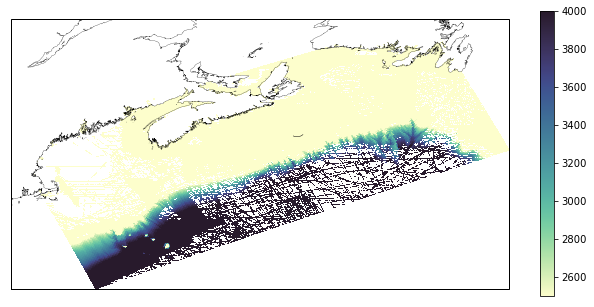

In [6]:
# colormap
cmap = cm.deep
cmap.set_bad('white')

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig, ax = plt.subplots(1, 1, figsize=(9, 7.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

pcm = ax.pcolormesh(gridInSitu['lon'], gridInSitu['lat'],
                    np.ma.masked_values(gridInSitu['depth'], 0.),
                    cmap=cmap,
                    vmin=2500.,
                    vmax=4000.,
                    transform=ccrs.PlateCarree())

ax.add_feature(coastline, linewidth=0.25)
fig.colorbar(pcm, ax=ax, shrink=.55)

# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/gridded_observations.pdf')

# save figure
fig.savefig(figname)

Let's have a look at the number of Observations at each grid point

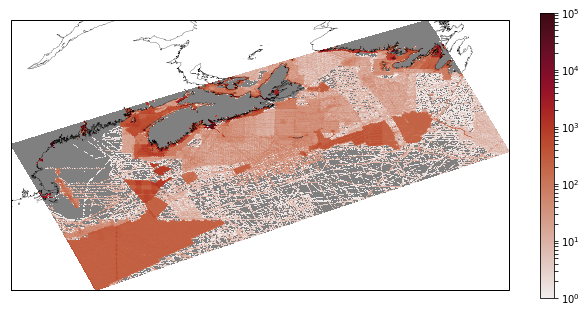

In [7]:
# colormap
cmap = cm.amp
cmap.set_bad('grey')

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig, ax = plt.subplots(1, 1, figsize=(9, 7.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

pcm = ax.pcolormesh(gridInSitu['lon'], gridInSitu['lat'],
                    np.ma.masked_values(gridInSitu['nobs'], 0.),
                    norm=colors.LogNorm(vmin=1., vmax=gridInSitu['nobs'].max()),
                    cmap=cmap,
                    #vmin=0.,
                    # vmax=200.,
                    transform=ccrs.PlateCarree())

ax.add_feature(coastline, linewidth=0.25)
fig.colorbar(pcm, ax=ax, shrink=.55)

# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/%s_bathymetry_observation_density.pdf' % conf)

# save figure
fig.savefig(figname)

## Step 3: Create Background Field for Optimal Interpolation

In [8]:
# interpolate ETOPO to NEMO grid
ETOPOint = etopo2nemo(NEMO, ETOPO)

# interpolate ETOPO to NEMO grid
GEBCOint = gebco2nemo(NEMO, GEBCO)

Interpolate ETOPO data to NEMO grid.
Interpolate ETOPO data to NEMO grid.


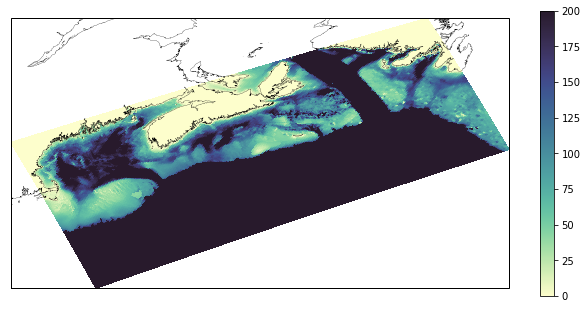

In [9]:
# colormap
cmap = cm.deep
cmap.set_bad('grey')

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig, ax = plt.subplots(1, 1, figsize=(9, 7.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

pcm = ax.pcolormesh(ETOPOint['lon'], ETOPOint['lat'],
                    np.ma.masked_values(ETOPOint['depth'], 0.),
                    cmap=cmap,
                    vmin=0.,
                    vmax=200.,
                    transform=ccrs.PlateCarree())

ax.add_feature(coastline, linewidth=0.25)
fig.colorbar(pcm, ax=ax, shrink=.55)

# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/ETOPO_on_GoMSS_grid.pdf')

# save figure
fig.savefig(figname)

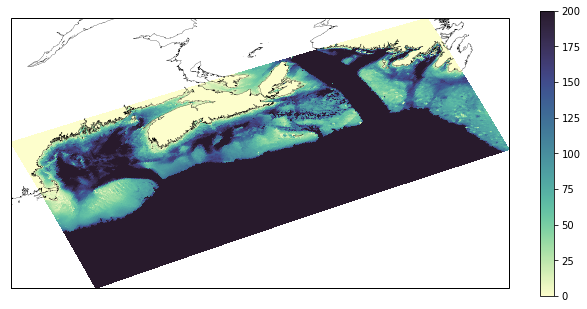

In [10]:
# colormap
cmap = cm.deep
cmap.set_bad('grey')

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig, ax = plt.subplots(1, 1, figsize=(9, 7.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

pcm = ax.pcolormesh(GEBCOint['lon'], GEBCOint['lat'],
                    np.ma.masked_values(GEBCOint['depth'], 0.),
                    cmap=cmap,
                    vmin=0.,
                    vmax=200.,
                    transform=ccrs.PlateCarree())

ax.add_feature(coastline, linewidth=0.25)
fig.colorbar(pcm, ax=ax, shrink=.55)

# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/GEBCO_on_GoMSS_grid.pdf')

# save figure
fig.savefig(figname)

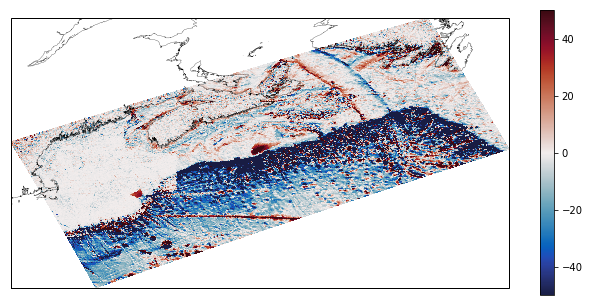

In [11]:
# colormap
cmap = cm.balance

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig, ax = plt.subplots(1, 1, figsize=(9, 7.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

pcm = ax.pcolormesh(GEBCOint['lon'], GEBCOint['lat'],
                    GEBCOint['depth'] - ETOPOint['depth'],
                    cmap=cmap,
                    vmin=-50.,
                    vmax=50.,
                    transform=ccrs.PlateCarree())

ax.add_feature(coastline, linewidth=0.25)
fig.colorbar(pcm, ax=ax, shrink=.55)

# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/GEBCO-ETOPO_on_GoMSS_grid.pdf')

# save figure
fig.savefig(figname)

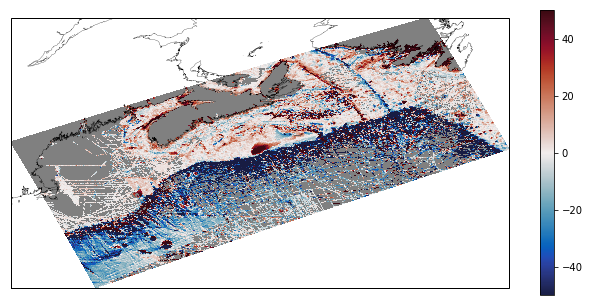

In [12]:
innov = gridInSitu['depth'] - ETOPOint['depth']
innov[innov == -ETOPOint['depth']] = 0.

# colormap
cmap = cm.balance
cmap.set_bad('grey')

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig, ax = plt.subplots(1, 1, figsize=(9, 7.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

pcm = ax.pcolormesh(gridInSitu['lon'], gridInSitu['lat'],
                    np.ma.masked_values(innov, 0.),
                    cmap=cmap,
                    vmin=-50.,
                    vmax=50.,
                    transform=ccrs.PlateCarree())

ax.add_feature(coastline, linewidth=0.25)
fig.colorbar(pcm, ax=ax, shrink=.55)

# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/innovation_ETOPO.pdf')

# save figure
fig.savefig(figname)

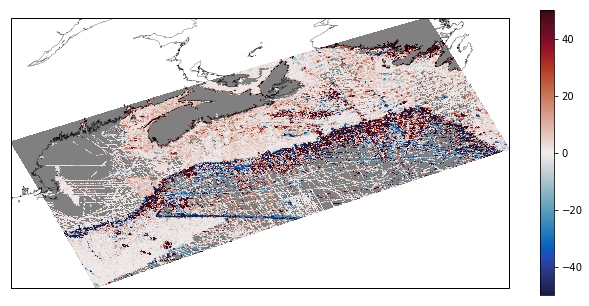

In [13]:
innov = gridInSitu['depth'] - GEBCOint['depth']
innov[innov == -GEBCOint['depth']] = 0.

# colormap
cmap = cm.balance
cmap.set_bad('grey')

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig, ax = plt.subplots(1, 1, figsize=(9, 7.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

pcm = ax.pcolormesh(gridInSitu['lon'], gridInSitu['lat'],
                    np.ma.masked_values(innov, 0.),
                    cmap=cmap,
                    vmin=-50.,
                    vmax=50.,
                    transform=ccrs.PlateCarree())

ax.add_feature(coastline, linewidth=0.25)
fig.colorbar(pcm, ax=ax, shrink=.55)

# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/innovation_GEBCO.pdf')

# save figure
fig.savefig(figname)

## Step 4: Optimal Interpolation

In [14]:
nstar = 500

# blend ETOPO and gridded in-situ observations
ana_etopo = optimal_interpolation(ETOPOint, gridInSitu, proj, delta, c, sigobs, nstar)


# blend ETOPO and gridded in-situ observations
ana_gebco = optimal_interpolation(GEBCOint, gridInSitu, proj, delta, c, sigobs, nstar)

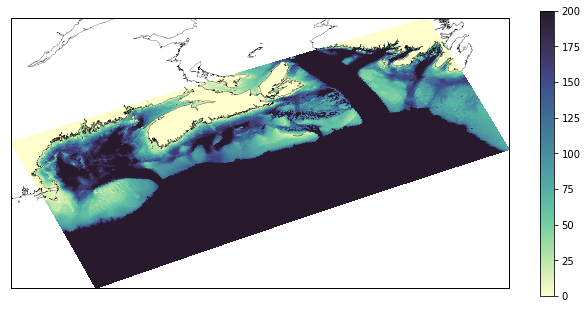

In [15]:
# colormap
cmap = cm.deep
cmap.set_bad('grey')

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig, ax = plt.subplots(1, 1, figsize=(9, 7.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

pcm = ax.pcolormesh(gridInSitu['lon'], gridInSitu['lat'],
                    np.ma.masked_values(ana_etopo, 0.),
                    cmap=cmap,
                    vmin=0.,
                    vmax=200.,
                    transform=ccrs.PlateCarree())

ax.add_feature(coastline, linewidth=0.25)
fig.colorbar(pcm, ax=ax, shrink=.55)

# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/%s_bathymetry_nstar_%s_etopo.pdf' % (conf, nstar))

# save figure
fig.savefig(figname)

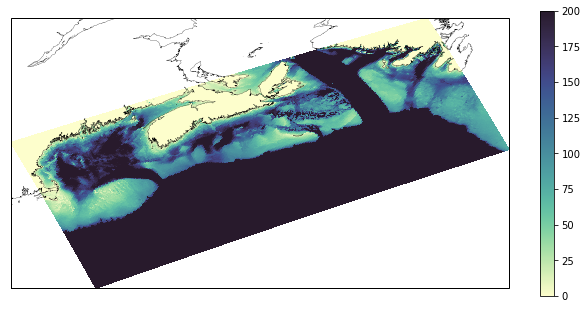

In [16]:
# colormap
cmap = cm.deep
cmap.set_bad('grey')

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig, ax = plt.subplots(1, 1, figsize=(9, 7.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

pcm = ax.pcolormesh(gridInSitu['lon'], gridInSitu['lat'],
                    np.ma.masked_values(ana_gebco, 0.),
                    cmap=cmap,
                    vmin=0.,
                    vmax=200.,
                    transform=ccrs.PlateCarree())

ax.add_feature(coastline, linewidth=0.25)
fig.colorbar(pcm, ax=ax, shrink=.55)

# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/%s_bathymetry_nstar_%s_gebco.pdf' % (conf, nstar))

# save figure
fig.savefig(figname)

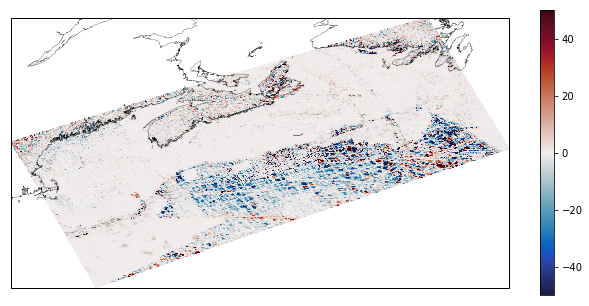

In [17]:
# colormap
cmap = cm.balance

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig, ax = plt.subplots(1, 1, figsize=(9, 7.5),
                       subplot_kw={'projection': ccrs.PlateCarree()})

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

pcm = ax.pcolormesh(GEBCOint['lon'], GEBCOint['lat'],
                    ana_gebco - ana_etopo,
                    cmap=cmap,
                    vmin=-50.,
                    vmax=50.,
                    transform=ccrs.PlateCarree())

ax.add_feature(coastline, linewidth=0.25)
fig.colorbar(pcm, ax=ax, shrink=.55)

# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/%s_bathymetry_nstar_%s_gebco-etopo.pdf' % (conf, nstar))

# save figure
fig.savefig(figname)

In [18]:
ana = ana_gebco

# write bathy_meter.nc file -----------------------------------------------
    
# file name
bfname = os.path.join(projdir, 'data/processed/bathy_meter.nc')

# create output file
bdata = nc.Dataset(bfname, 'w')

# create dimensions
bdata.createDimension('x', NEMO.dims['x'])
bdata.createDimension('y', NEMO.dims['y'])

# create variables
olon = bdata.createVariable('nav_lon', float, ('y', 'x')) 
olat = bdata.createVariable('nav_lat', float, ('y', 'x'))
obathy = bdata.createVariable('Bathymetry', float, ('y', 'x'),
                              fill_value=0.)

# write fields to file
olat[:] = NEMO.gphit.values
olon[:] = NEMO.glamt.values
obathy[:] = ana

# variable atttributes
olon.units = 'degrees_east'
olon.valid_min = NEMO.glamt.values.min()
olon.valid_max = NEMO.glamt.values.max()

olat.units = 'degrees_north'
olat.valid_min = NEMO.gphit.values.min()
olat.valid_max = NEMO.gphit.values.max()

obathy.units = 'meters'
obathy.sign = 'positive up'

# global attributes
bdata.author = 'Christoph Renkl (christoph.renkl@dal.ca)'
bdata.date = time.strftime("%Y-%m-%d")

# close files
bdata.close()

## Step 5: Create Land-Sea Mask

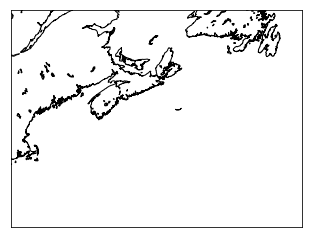

In [19]:
# create land-sea mask
mask = land_sea_mask(NEMO, proj)

# apply land-sea mask and set land values to zero
ana = np.copy(ana)
ana[(ana < 0) | (mask == 1.)] = 0.

## Step 6: Set Minimum Depth

In [20]:
ana = minimum_depth(ana, NEMO, WebTide, proj, hmin, ampfac)

Set minimum depth depending on according to Maraldi et al. (2013).


## Step 7: Remove Closed Seas

In [21]:
ana = remove_closed_seas(ana)

Remove closed seas as in AGRIF nesting tools


## Plot New Bathymetry

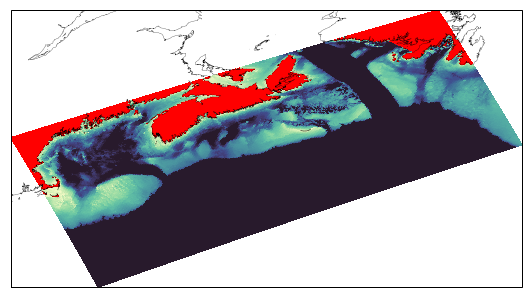

In [22]:
# colormap
cmap = cm.deep
cmap.set_bad('red')

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig = plt.figure(figsize=(7.5, 9.))
ax = plt.axes(projection=ccrs.PlateCarree())

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

ax.pcolormesh(NEMO['glamt'], NEMO['gphit'],
              np.ma.masked_values(ana, 0.),
              cmap=cmap,
              vmin=0.,
              vmax=200.)
ax.add_feature(coastline, linewidth=0.25)


# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/%s_bathymetry_gebco.pdf' % conf)

# save figure
fig.savefig(figname)

In [23]:
data = xr.open_dataset('/data/po/jasket/chrenkl/Models/GoMSS/Output/R001keps_noevd/R001keps_noevd_1h_Harmonic_TideT_20100201-20100228.nc')

Xt = np.empty((218+1, 668+1))
Xt[:-1, :-1] = data['bounds_lon'][..., 0]
Xt[-1, :-1] = data['bounds_lon'][-1,:, 3]
Xt[:-1, -1] = data['bounds_lon'][:,-1, 1]
Xt[-1, -1] = data['bounds_lon'][-1,-1, 2]

Yt = np.empty((218+1, 668+1))
Yt[:-1, :-1] = data['bounds_lat'][..., 0]
Yt[-1, :-1] = data['bounds_lat'][-1,:, 3]
Yt[:-1, -1] = data['bounds_lat'][:,-1, 1]
Yt[-1, -1] = data['bounds_lat'][-1,-1, 2]


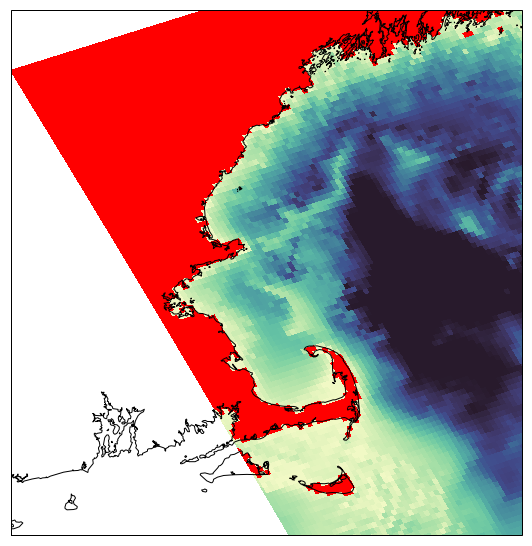

In [24]:
# colormap
cmap = cm.deep
cmap.set_bad('red')

# coordinate limits
lonmin = NEMO.glamt.values.min()
lonmax = -69.
latmin = 41.
latmax = 44.

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig = plt.figure(figsize=(7.5, 9.))
ax = plt.axes(projection=ccrs.PlateCarree())

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

ax.pcolormesh(Xt, Yt,
              np.ma.masked_values(ana, 0.),
              cmap=cmap,
              vmin=0.,
              vmax=200.)

ax.add_feature(coastline, linewidth=1.)


# layout
fig.tight_layout()

## Comparison with Anna's orginal GoMSS bathymetry based on ETOPO2

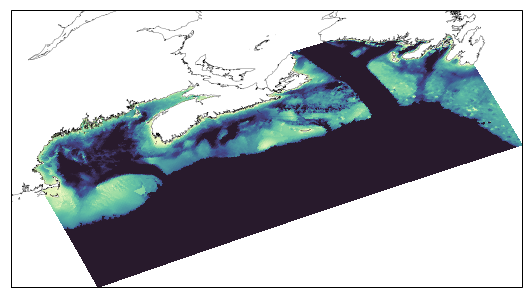

In [25]:
# colormap
cmap = cm.deep
cmap.set_bad('white')

# coordinate limits
lonmin = NEMO.glamt.values.min()
lonmax = NEMO.glamt.values.max()
latmin = NEMO.gphit.values.min()
latmax = NEMO.gphit.values.max()

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig = plt.figure(figsize=(7.5, 9.))
ax = plt.axes(projection=ccrs.PlateCarree())

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

ax.pcolormesh(NEMOorig['nav_lon'], NEMOorig['nav_lat'],
              np.ma.masked_values(NEMOorig['Bathymetry'], 0.),
              cmap=cmap,
              vmin=0.,
              vmax=200.)
ax.add_feature(coastline, linewidth=0.25)


# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/%s_original_bathymetry_etopo2.pdf' % conf)

# save figure
fig.savefig(figname)

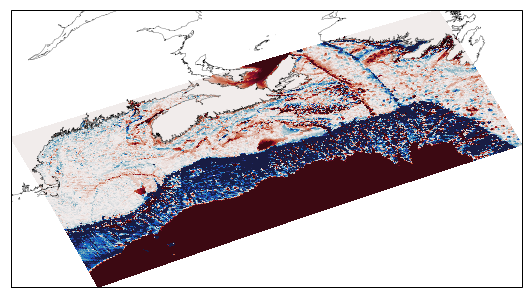

In [26]:
# colormap
cmap = cm.balance
cmap.set_bad('white')

# coordinate limits
lonmin = NEMO.glamt.values.min()
lonmax = NEMO.glamt.values.max()
latmin = NEMO.gphit.values.min()
latmax = NEMO.gphit.values.max()

# Figure 1:
# -------------------------------------------------------------------------

# create figure        
fig = plt.figure(figsize=(7.5, 9.))
ax = plt.axes(projection=ccrs.PlateCarree())

coastline = cfeature.GSHHSFeature(scale='h')

ax.set_extent([lonmin, lonmax, latmin, latmax], ccrs.PlateCarree())

ax.pcolormesh(NEMOorig['nav_lon'], NEMOorig['nav_lat'],
              ana - NEMOorig['Bathymetry'],
              cmap=cmap,
              vmin=-50.,
              vmax=50.)
ax.add_feature(coastline, linewidth=0.25)


# layout
fig.tight_layout()

# file name of cleaned and corrected insitu data
figname = os.path.join(projdir, 'reports/figures/%s_new-old_bathymetry.pdf' % conf)

# save figure
fig.savefig(figname)